In [1]:
import os
from os.path import join

import numpy as np

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

datapath = join('data', 'wafer')

Using TensorFlow backend.


In [2]:
# 케라스 백 엔드인 텐서플로우의 세션 설정을 불러옵니다.
from keras.backend.tensorflow_backend import set_session

# 텐서플로우의 ConfigProto() 객체에 학습시 적용할 옵션들을 명시적으로 설정할 수 있습니다.
config = tf.ConfigProto()
# GPU 옵션으로 allow_grouth를 True로 설정합니다.
config.gpu_options.allow_growth = True 

# 텐서플로우는 세션이라는 실행 단위를 가지고 있는데, 해당 세션에 적용할 옵션을 담고있는 Config객체를 전달합니다.
sess = tf.Session(config=config)
# 설정한 세션을 현재 프로세스에 적용합니다.
set_session(sess)  

## 1. 데이터 살펴보기
이번 실습에서 사용할 데이터는 kaggle에 공개되어 있는 Wafer map 데이터 입니다. <br>
지난 AutoEncoder 실습에서 Data Augmentation에서 사용을 했었습니다.<br>
이번에는 Wafer 이미지를 CNN 네트워크를 통해 Center, Donut, Edge-Loc, Edge-Ring, Loc, Random, Scratch, Near-full, none 9개 종류의 불량 케이스를 분류해보겠습니다.


![Kaggle_Wafer](./Images/kaggle_wafer.png)

In [3]:
# numpy 행렬 파일로 저장해둔 데이터를 가져옵니다.

x = np.load(join(datapath, 'wafermap_class_(26,26).npy'))
y = np.load(join(datapath, 'wafer_labels.npy'))

In [4]:
# 데이터의 차원을 살펴보겠습니다.
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


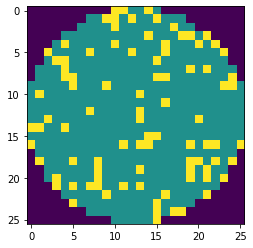

Faulty case : ['none'] 


In [5]:
# 0번째 데이터 이미지 확인
plt.imshow(x[0])
plt.show()

# 해당 이미지의 불량 케이스 확인
print('Faulty case : {} '.format(y[0]))

데이터의 검정 부분은 Wafer가 없는 부분으로 0, 초록 부분은 정상을 나타내는 부분으로 1, 노랑 부분은 불량을 나타내는 부분으로 2 값을 가지고 있습니다.

## 2. 전처리 하기
### Wafer 이미지에 채널을 추가하기
Wafer 데이터는 26\*26 이미지이므로 CNN에 넣기 위해서는 채널을 만들어주어야 합니다. <br>
numpy.reshape() 함수를 사용해 1개의 채널을 추가하겠습니다.

In [6]:
# 채널 추가
x = x.reshape((-1, 26, 26, 1))

### 클래스 불균형을 확인하기
먼저 각 불량 케이스 별 데이터들의 불균형을 확인 해보겠습니다.

In [7]:
# numpy.unique() 함수는 배열 내에 들어있는 고유한 값들을 반환합니다.
faulty_case = np.unique(y)
print('불량 케이스 목록 : {}'.format(faulty_case))

불량 케이스 목록 : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [8]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


데이터의 불균형이 심한 것을 확인할 수 있습니다. none의 경우 90% 이상의 비율을 차지하고 있습니다.<br>
이런 경우 모델이 none 클래스로 찍기만 해도 정확도가 90% 정도가 나올 것을 예상할 수 있습니다. <br>
따라서 클래스 불균형 문제를 해결하기 위해 이전 수업에서 사용했던, 생성 모델들을 통해 데이터를 추가해보겠습니다.

### One-hot Ecnoding for categorical variables

AutoEncoder에 이미지를 넣기 전에 Wafer 이미지의 픽셀 값은 0, 1, 2의 범주형 변수로 이루어져 있습니다.<br>
이를 채널 방향으로 One-hot-Encoding을 진행하면, 모델에게 각 채널별로 범주형 변수를 이해할 수 있도록 할 수 있습니다.

In [9]:
# 채널별로 One-hot-Encoding한 데이터를 담을 틀을 생성합니다.
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

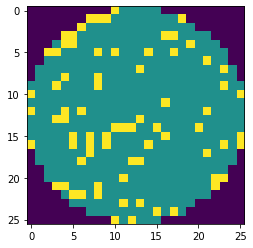

In [10]:
# 채널 방향으로 One-hot-Encoding 하기 이전의 이미지
plt.imshow(x[1].reshape(26,26))

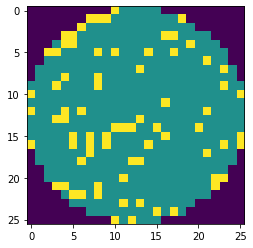

In [11]:
# 채널 방향(axis=2)으로 argmax 취하면, 이전의 이미지와 동일한 이미지를 얻을 수 있습니다.
plt.imshow(np.argmax(new_x[1], axis=2))

In [12]:
# 변환한 새로운 x의 차원을 살펴보겠습니다.
new_x.shape

(14366, 26, 26, 3)

이제 데이터가 준비되었으니, 준비된 데이터로 불균형 문제를 해결해보겠습니다

### Convolution AutoEncoder

In [ ]:
# parameter
epoch=10
batch_size=1024

In [ ]:
# Encoder 부분
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(   , (3,3), activation='')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder 부분, Decoder는 레이어에 바로 이전 값을 넣지 않고, Layer 자체로 변수로 저장합니다.
decode_layer_1 = layers.Conv2DTranspose(, (3,3), activation='')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(, (3,3), activation='')

# 레이어로 저장한 Decoder Layer에 Latent vector 부터 순서대로 Decoding하며 연결합니다.
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

# AutoEncoder 모델 정의
ae = models.Model(input_tensor, output_tensor(decode))

# AutoEncoder 모델 생성(컴파일), 최적화기는 Adam, 비용 함수는 mse를 사용합니다.
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [ ]:
ae.summary()

In [ ]:
# AutoEncoder 모델 학습
ae.fit(, ,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

In [ ]:
# Encoder 모델 정의 *compile을 통해 모델을 생성하지 않는 이유는 이미 ae 모델에서 compile과 학습을 마쳤기 때문입니다.
encoder = models.Model(, )

In [ ]:
# Decoder 모델
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)
# Decoder 모델 정의, *compile을 통해 모델을 생성하지 않는 이유는 이미 ae 모델에서 compile과 학습을 마쳤기 때문입니다.
decoder = models.Model(decoder_input, output_tensor(decode))

In [ ]:
# 원본 불량 데이터 인코딩
encoded_x = encoder.predict(new_x)

In [ ]:
# 원본 불량 데이터를 축소시켜 만든 Latent 데이터에 약간의 노이즈를 더해 새로운 데이터를 생성 합니다.
# numpy.random.normal 함수는 loc=평균, scale=표준편차를 가진 정규 분포 노이즈를 생성 합니다.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

In [ ]:
# 원본 불량 데이터 확인
plt.imshow(np.argmax(new_x[3], axis=2))

In [ ]:
# 노이즈를 섞어 만든 불량 데이터 확인
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

In [ ]:
# AutoEncoder가 복원시킨 원본 불량 데이터 확인
gen_x = np.argmax(ae.predict(new_x), axis=3)
plt.imshow(gen_x[3])

이렇게 AutoEncoder로 추가 데이터를 생성할 수 있습니다. 입력된 불량 케이스마다 2천개 이상의 데이터를 가지고 있도록 데이터를 생성하여 클래스 불균형 문제를 완화하겠습니다. <br>
함수 형태로 손쉽게 사용할 수 있도록 합니다.

In [ ]:
def gen_data(wafer, label):
    # 입력 받은 wafer 이미지를 Encoding 합니다.
    encoded_x = encoder.predict(wafer)
    
    # 생성한 wafer 데이터를 모을 틀을 만듭니다.
    gen_x = np.zeros((1, 26, 26, 3))
    
    # 각 클래스가 가지고 있는 데이터의 수가 2천개가 되도록 반복하여 데이터를 생성합니다.
    # ex) 가지고 있는 데이터의 수가 2개라면, 2000//2 = 1000, 한번에 2개씩 1000번 2천개의 데이터를 생성합니다.
    for i in range((2000//len(wafer)) + 1):
        # Encoding한 데이터에 노이즈를 가해 새로운 데이터를 생성합니다.
        
        #먼저 노이즈를 생성할 데이터의 수만큼 만들고 기존의 데이터에 노이즈를 더해줍니다
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        
        #노이즈가 더해진 기존의 Latent Vector를 Decode하여 새로운 값을 생성합니다
        noised_gen_x = decoder.predict(noised_encoded_x)
        
        #만들어진 데이터를 기존의 데이터에 추가해줍니다
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
        
    # 생성한 데이터의 개수에 맞게 레이블도 생성해줍니다.
    gen_y = np.full((len(gen_x), 1), label)
    
    # 데이터를 반환할 때 0번 인덱스에 있는 데이터는 가짜 데이터이므로 제외하고 반환합니다.
    return gen_x[1:], gen_y[1:]

데이터 생성을 시작합니다. gen_data 함수에 각 클래스별 wafer 데이터와 라벨을 전달합니다.<br>
np.where() 함수를 사용해, 불량 클래스에 맞는 인덱스를 추출합니다.

In [ ]:
# 모든 불량 케이스에 대해 반복문을 수행합니다.
for f in faulty_case : 
    # none 클래스에 대해서는 데이터를 생성하지 않습니다.
    if f == 'none' : 
        continue
    # 현재 불량 케이스에 대한 wafer 이미지와, 라벨 값을 전달해 데이터를 생성합니다.
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [ ]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

데이터를 생성했으니 클래스 별 분포를 살펴보겠습니다.

In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

none class를 제외하고, 각 클래스의 데이터가 2천개 정도로 늘어났습니다.<br>
none 클래스는 임의 추출을 통해 2천개로 줄이겠습니다.

In [ ]:
# replace 옵션을 False로 주어 중복 없이 추출하도록 합니다.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [ ]:
# 임의로 추출한 인덱스로 none 데이터를 제거합니다. 
# numpy.delete() 함수는 인덱스 번호로 데이터를 제거할 수 있고, axis 를 통해 인덱스 방향을 지정할 수 있습니다.
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [ ]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))


In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

### 왜 벡터를 사용하나요
여기에서 Label 데이터를 그대로 숫자로 표현해도 되지만, 벡터로 표현한 것은 숫자 이미지라는 특성이 수치적으로 1씩 증가하는 관계가 아니기 때문에<br>
서로 독립적인 관계를 갖는 벡터로 표현해주는 것이 더 적절합니다. 이러한 기법을 One-hot encoding이라 합니다.<br>
Keras에서는 연속 정수형을 벡터형태로 변환해주는 to_categorical() 함수가 존재합니다.

In [ ]:
# 문자열로 되어있는 label 값을 숫자 형태로 변경합니다.
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# label 값을 벡터 형태로 표현합니다.
new_y = to_categorical(new_y)

In [ ]:
# 전처리가 끝난 데이터를 학습 데이터와 검증 데이터로 나눕니다.
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [ ]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

## 3. CNN 모델 만들어보기

In [ ]:
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)

In [ ]:
# 은닉층
conv = layers.Conv2D()(input_tensor)

flat = layers.Flatten()(conv)

dense = layers.Dense()(flat)

# 출력층
output_tensor = layers.Dense(9, activation='softmax')(dense)

In [ ]:
# 모델 정의
model = models.Model()
# 모델 생성(컴파일)
model.compile(optimizer=,
             loss=,
             metrics=[])

In [ ]:
history = model.fit(
         validation_data=[],
         epochs=,
         batch_size=,
         verbose=2
         )

In [ ]:
# 정확도 그래프를 그립니다.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 비용 함수 그래프를 그립니다.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

검증 데이터에 대해 어느정도 높은 정확도의 결과를 보여주었습니다.<br>
하지만 한가지 주의하셔야 하는 점은 대부분의 데이터가 매우 적은 소수의 데이터에서 생성되었기 때문에 Train, Test로 데이터를 쪼갰다 하더라도<br>
모델이 Test 데이터를 관찰하지 않았다고(Unseen Data)하기 어렵습니다. <br>
이 부분은 감안하시면 좋겠습니다. 지금까지 고생 많으셨습니다. <br>